# Learning rate - Problem 8
## Description

### Average time : 100 minutes

### PDE
We will try to find the best learning rate to the problem 8 of the article: https://ieeexplore.ieee.org/document/712178  

$\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}= f(x,y)$ on $\Omega = [0,1]^2$  
where $f(x, y)=\sin(\pi x)(2-\pi^2y^2+2y^3\sin(\pi x))$   

### Boundary conditions    
$\psi(0,y)=\psi(1,y)=\psi(x,0)=0$ and $\frac{\partial \psi}{\partial y}(x,1)=2\sin(\pi x)$           

### Loss function
The loss to minimize here is $\mathcal{L} = ||\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}-f(x,y) ||_2$  

### Analytical solution
The true function $\psi$ should be $\psi(x, y)=y^2sin(\pi x)$  
This solution is the same of the problem 7

### Approximated solution
We want find a solution $\psi(x,y)=A(x,y)+F(x,y)N(x,y)$
s.t:  
$F(x,y)=\sin(x-1)\sin(y-1)\sin(x)\sin(y)$ 
$A(x,y)=y\sin(\pi x)$   


# Importing libraries

In [2]:
# Jax libraries
from jax import value_and_grad,vmap,jit,jacfwd
from functools import partial 
from jax import random as jran
from jax.example_libraries import optimizers as jax_opt
from jax.nn import tanh, sigmoid, elu, relu, gelu
from jax.lib import xla_bridge
import jax.numpy as jnp

# Others libraries
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
print(xla_bridge.get_backend().platform)

gpu


# Multilayer Perceptron

In [9]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    
    # Class initialization
    def __init__(self,SEED,layers):
        self.key=jran.PRNGKey(SEED)
        self.keys = jran.split(self.key,len(layers))
        self.layers=layers
        self.params = []

    # Initialize the MLP weigths and bias
    def MLP_create(self):
        for layer in range(0, len(self.layers)-1):
            in_size,out_size=self.layers[layer], self.layers[layer+1]
            std_dev = jnp.sqrt(2/(in_size + out_size ))
            weights=jran.truncated_normal(self.keys[layer], -2, 2, shape=(out_size, in_size), dtype=np.float32)*std_dev
            bias=jran.truncated_normal(self.keys[layer], -1, 1, shape=(out_size, 1), dtype=np.float32).reshape((out_size,))
            self.params.append((weights,bias))
        return self.params
        
    # Evaluate a position XY using the neural network    
    @partial(jit, static_argnums=(0,))    
    def NN_evaluation(self,new_params, inputs):
        for layer in range(0, len(new_params)-1):
            weights, bias = new_params[layer]
            inputs = gelu(jnp.add(jnp.dot(inputs, weights.T), bias))
        weights, bias = new_params[-1]
        output = jnp.dot(inputs, weights.T)+bias
        return output
    
    # Get the key associated with the neural network
    def get_key(self):
        return self.key


# Two dimensional PDE operators

In [10]:
class PDE_operators2d:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self,function):
        self.function=function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_xx = jacfwd(jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jacfwd(jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
        return laplacian

    # Compute the partial derivative in x
    @partial(jit, static_argnums=(0,))    
    def du_dx(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_x = jacfwd(fun, 1)(params,x,y)
            return u_x
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

    # Compute the partial derivative in y
    @partial(jit, static_argnums=(0,))    
    def du_dy(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_y = jacfwd(fun, 2)(params,x,y)
            return u_y
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

# Physics Informed Neural Networks

In [11]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self,NN_evaluation):
        self.operators=PDE_operators2d(self.solution)
        self.laplacian=self.operators.laplacian_2d
        self.NN_evaluation=NN_evaluation
        self.dsol_dy=self.operators.du_dy

    # Definition of the function A(x,y) mentioned above
    @partial(jit, static_argnums=(0,))    
    def A_function(self,inputX,inputY):
        return jnp.multiply(inputY,jnp.sin(jnp.pi*inputX)).reshape(-1,1)

    # Definition of the function F(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def F_function(self,inputX,inputY):
        F1=jnp.multiply(jnp.sin(inputX),jnp.sin(inputX-jnp.ones_like(inputX)))
        F2=jnp.multiply(jnp.sin(inputY),jnp.sin(inputY-jnp.ones_like(inputY)))
        return jnp.multiply(F1,F2).reshape((-1,1))

    # Definition of the function f(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def target_function(self,inputs):
        return jnp.multiply(jnp.sin(jnp.pi*inputs[:,0]),2-jnp.pi**2*inputs[:,1]**2+2*inputs[:,1]**3*jnp.sin(jnp.pi*inputs[:,0])).reshape(-1,1) 

    # Compute the solution of the PDE on the points (x,y)
    @partial(jit, static_argnums=(0,))    
    def solution(self,params,inputX,inputY):
        inputs=jnp.column_stack((inputX,inputY))
        NN = vmap(partial(jit(self.NN_evaluation), params))(inputs)
        F=self.F_function(inputX,inputY)
        A=self.A_function(inputX,inputY)
        return jnp.add(jnp.multiply(F,NN),A).reshape(-1,1)

    # Compute the loss function
    @partial(jit, static_argnums=(0,))    
    def loss_function(self,params,batch):
        targets=self.target_function(batch)
        laplacian=self.laplacian(params,batch).reshape(-1,1)
        dsol_dy_values=self.dsol_dy(params,batch)[:,0].reshape((-1,1))
        preds=laplacian+jnp.multiply(self.solution(params,batch[:,0],batch[:,1]),dsol_dy_values).reshape(-1,1)
        return jnp.linalg.norm(preds-targets)
 
    # Train step
    @partial(jit, static_argnums=(0,))    
    def train_step(self,i, opt_state, inputs):
        params = get_params(opt_state)
        loss, gradient = value_and_grad(self.loss_function)(params,inputs)
        return loss, opt_update(i, gradient, opt_state)

# Initialize neural network

In [12]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 1            # Input and output dimension
layers = [n_features,30,n_targets]      # Layers structure

# Initialization
NN_MLP=MLP(SEED,layers)                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval=NN_MLP.NN_evaluation            # Evaluate function
solver=PINN(NN_eval)
key=NN_MLP.get_key()

# Train parameters

In [13]:
batch_size = 50
num_batches = 100000
report_steps=1000

# Learning rate

In [14]:
init, end, interval_lenght = 0, 10, 5
# Learning rate values
intervals = jnp.array([jnp.linspace(10**(-i),10**(-i)/interval_lenght,interval_lenght) for i in range(init,end)])
learning_rate = intervals.reshape(-1,1)[:,0]
print(learning_rate)

[1.0000000e+00 8.0000001e-01 6.0000002e-01 4.0000001e-01 2.0000000e-01
 1.0000000e-01 8.0000006e-02 6.0000002e-02 3.9999999e-02 2.0000000e-02
 9.9999998e-03 7.9999994e-03 6.0000001e-03 3.9999997e-03 2.0000001e-03
 1.0000000e-03 7.9999998e-04 6.0000003e-04 4.0000002e-04 1.9999999e-04
 9.9999997e-05 7.9999998e-05 5.9999998e-05 3.9999999e-05 1.9999999e-05
 9.9999997e-06 8.0000000e-06 5.9999998e-06 4.0000000e-06 2.0000000e-06
 1.0000000e-06 8.0000001e-07 6.0000002e-07 4.0000000e-07 2.0000000e-07
 1.0000000e-07 8.0000000e-08 5.9999998e-08 4.0000000e-08 2.0000000e-08
 9.9999999e-09 7.9999998e-09 6.0000001e-09 3.9999999e-09 1.9999999e-09
 9.9999997e-10 7.9999996e-10 5.9999999e-10 3.9999998e-10 2.0000000e-10]


# Solving PDE

In [15]:
# Main loop find the best learning rate
counter=0
min_index=jnp.inf
min_loss_value = jnp.inf
minimum_loss=[]

# Create a file to save the learning rate
file_data_learn=open('./learning_rate','w')
file_data_learn.close()

# Create a file to save the last value of the loss function
file_data_loss=open('./loss_function','w')
file_data_loss.close()

for i in range(len(learning_rate)):
    loss_history = []
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate[i])

    NN_MLP=MLP(SEED,layers)                 
    params = NN_MLP.MLP_create()            # Create the MLP
    NN_eval=NN_MLP.NN_evaluation            # Evaluate function
    solver=PINN(NN_eval)                    # Use PINN on the problem 8
    key=NN_MLP.get_key()                    # Get the key of NN

    opt_state = opt_init(params)            # Initialize opt_state
    
    for ibatch in range(0,num_batches):
        ran_key, batch_key = jran.split(key)
        XY_train = jran.uniform(batch_key, shape=(batch_size, n_features), minval=0, maxval=1)

        loss, opt_state = solver.train_step(ibatch,opt_state, XY_train)
        loss_history.append(float(loss))

        if ibatch%report_steps==report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

    print("iteration",i,"of",len(learning_rate)-1)
    print(loss_history[num_batches-1],learning_rate[i])
    minimum_loss.append(loss_history[num_batches-1])

    # Get the index for the best learning rate
    if loss_history[num_batches-1]<min_loss_value:
        min_loss_value = loss_history[num_batches-1]
        min_index=i
        print('minimum value',minimum_loss[i])

    # Save the learning rate
    file_data_learn=open('./learning_rate','a')
    file_data_learn.write(str(learning_rate[i])+',')
    file_data_learn.close()

    # Save the last value of the loss function
    file_data_loss=open('./loss_function','a')
    file_data_loss.write(str(loss_history[num_batches-1])+',')
    file_data_loss.close()

Epoch n°1000:  2.6494688987731934
Epoch n°2000:  2.6326286792755127
Epoch n°3000:  2.640900135040283
Epoch n°4000:  2.6368932723999023
Epoch n°5000:  3.3558623790740967
Epoch n°6000:  3.3609070777893066
Epoch n°7000:  3.3572230339050293
Epoch n°8000:  3.3592758178710938
Epoch n°9000:  3.3630776405334473


KeyboardInterrupt: 

# Plot learning rate optimization

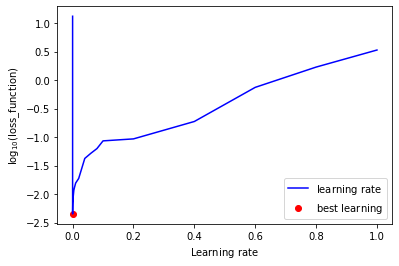

best learning rate = 8e-05


In [3]:
min_index=21
learning_rate=[1.0,0.8,0.6,0.4,0.2,0.1,0.080000006,0.060000002,0.04,0.02,0.01,0.007999999,0.006,0.0039999997,0.002,0.001,0.0008,0.0006,0.00040000002,0.0002,1e-04,8e-05,6e-05,4e-05,2e-05,1e-05,8e-06,5.9999998e-06,4e-06,2e-06,1e-06,8e-07,6e-07,4e-07,2e-07]
minimum_loss = [3.3589024543762207,1.6859272718429565,0.7435639500617981,0.18740606307983398,0.09280005842447281,0.08564911037683487,0.0627373605966568,0.05191640928387642,0.042144015431404114,0.01877341978251934,0.015574362128973007,0.014206845313310623,0.012948434799909592,0.0116304662078619,0.008996258489787579,0.007506238296627998,0.007247768342494965,0.006883973255753517,0.00629028957337141,0.005276193842291832,0.0048086014576256275,0.004483499098569155,0.004564367700368166,0.004636757075786591,0.006352274678647518,0.12315638363361359,0.28303778171539307,2.195760726928711,3.325516700744629,5.538702487945557,9.323655128479004,10.287568092346191,11.251932144165039,12.199068069458008,13.138975143432617]

fig, ax = plt.subplots(1, 1)
__=ax.plot(learning_rate,np.log10(minimum_loss),color='blue')
__=ax.scatter(learning_rate[min_index],np.log10(minimum_loss[min_index]),color='red')
legend = ax.legend([r'${\rm learning \ rate}$',r'${\rm best \ learning }$'])
xlabel = ax.set_xlabel(r'${\rm Learning \ rate}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss\_function)}$')
#title = ax.set_title(r'${\rm Learning \ rate \ optimization}$')
plt.show()
print("best learning rate =",learning_rate[min_index])